<b>AML2019</b>

<h3>Challenge 1</h3>
<h1>House Pricing Prediction</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<i>22<sup>th</sup> March 2019</i>

In [55]:
import pandas as pd
import pylab as plt
import numpy as  np
import seaborn as sns
from scipy import stats
path='challenge_data/'

The first AML challenge for this year is adapted from the well-known '<i>Zillow's Home Value Prediction</i>' competition on Kaggle.
In particular, given a dataset containing descriptions of homes on the US property market, your task is to make predictions on the selling price of as-yet unlisted properties. 
Developing a model which accurately fits the available training data while also generalising to unseen data-points is a multi-faceted challenge that involves a mixture of data exploration, pre-processing, model selection, and performance evaluation.

# Overview
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

Beyond simply producing a well-performing model for making predictions, in this challenge we would like you to start developing your skills as a machine learning scientist.
In this regard, your notebook should be structured in such a way as to explore the five following tasks that are expected to be carried out whenever undertaking such a project.
The description below each aspect should serve as a guide for your work, but you are strongly encouraged to also explore alternative options and directions. 
Thinking outside the box will always be rewarded in these challenges.

<div class="">
    <h3>1. Data Exploration and Vizualisation</h3>
</div>

In [56]:
houseDF= pd.read_csv(path+'train.csv')
houseDF.shape

(1200, 81)

In [57]:
houseDF.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


First, let's chech the amount of missing values:

In [58]:
print(houseDF.isnull().sum())

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       210
LotArea             0
Street              0
Alley            1125
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          6
MasVnrArea          6
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       564
GarageType         67
GarageYrBlt        67
GarageFinish       67
GarageCars          0
GarageArea          0
GarageQual         67
GarageCond         67
PavedDrive

C:\Users\kassa\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


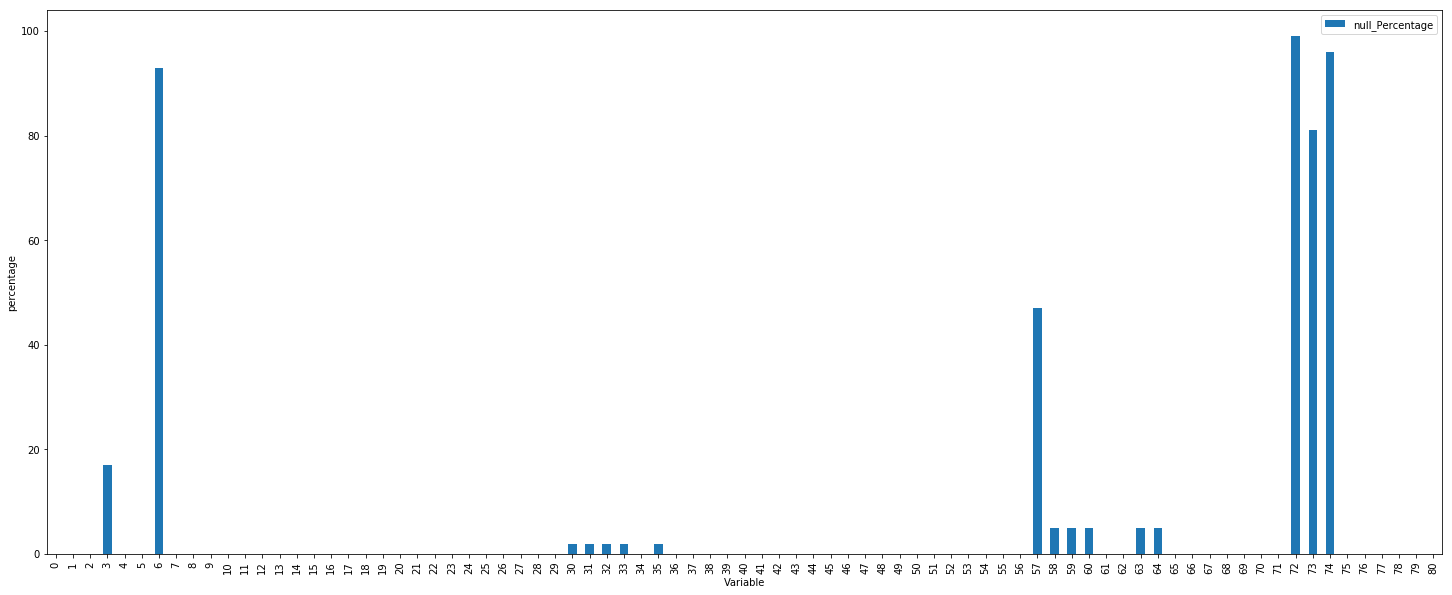

In [59]:
#Calculate the percentage of null values for each variable
nullDist=houseDF.isnull().sum().reset_index()
nullDist.columns=['column_name', 'null_Percentage']
c=houseDF.Id.count()
for i,v in nullDist.null_Percentage.iteritems():
    nullDist.null_Percentage[i]=(v*100)/c

fig, ax = plt.subplots(figsize=(25,10))
nullDist.plot.bar(ax=ax)    
ax.set_xlabel('Variable')
ax.set_ylabel('percentage')

#Save the plot in Output folder
plt.show()

The attributes containing most missing data are:
- PoolQC that contains 99% of missing values. This attribute gives the quality of the pool. Thus we might conclude that most of the houses of the dataset don't have a pool. This attribute has a lot of missing data, but deleting it would not be accurate, as a pool usually makes a great difference when it comes to the price of a house. However, there is a clear correlation with the attribute PoolArea.
- MiscFeature that contains 96% of missing values. This attribute gives the miscellaneous feature not covered in other categories. There are four possible values: shed, Gar2 and Othr. 
- Alley contains 94% of missing values.  This attribute gives the Type of alley access. It has two values : Grvl for gravel and Pave. The missing values must simply come from a lack of information about the type of alley.
- Fence contains  81% of missing values. It gives an idea about the quality of the Fence. Thus we might conclude that most of the houses of the dataset don't have a fence.

Now, let's check for the mean and standard deviation for Sales price

In [60]:
houseDF['SalePrice'].describe()

count      1200.000000
mean     181414.628333
std       81070.908544
min       34900.000000
25%      129900.000000
50%      163700.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

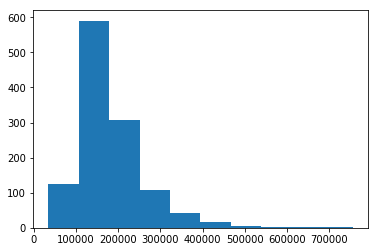

Skew is: 1.9672153474609588


In [61]:
plt.hist(houseDF.SalePrice)
plt.show()

# Determining the Skewness of data 
print ("Skew is:", houseDF.SalePrice.skew())

Skewness is a measure of the balance of the distribution. A normal distribution has a skewness value of 0. Here, we notice that the data is right skewed, which means that there are outliers greater than the mean. To make the optimization step of our prediction algorithms easier, it is important to standardize our data. We will compute the standardization and normalization in the Data Pre-processing.

Now let's identify the numerical and categorical variables:

In [62]:
# We create the dataframe of numerical values:
numerical_val = houseDF.select_dtypes(include=[np.number])
# Dataframe of categorical variables:
categorical_val= houseDF.select_dtypes(include=[np.object])

In [63]:
numerical_val.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [64]:
categorical_val.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

Now, let's study the possible correlations in the numerical variables:

In [65]:
#we create the correlation matrix
matrix_corr = numerical_val.corr()

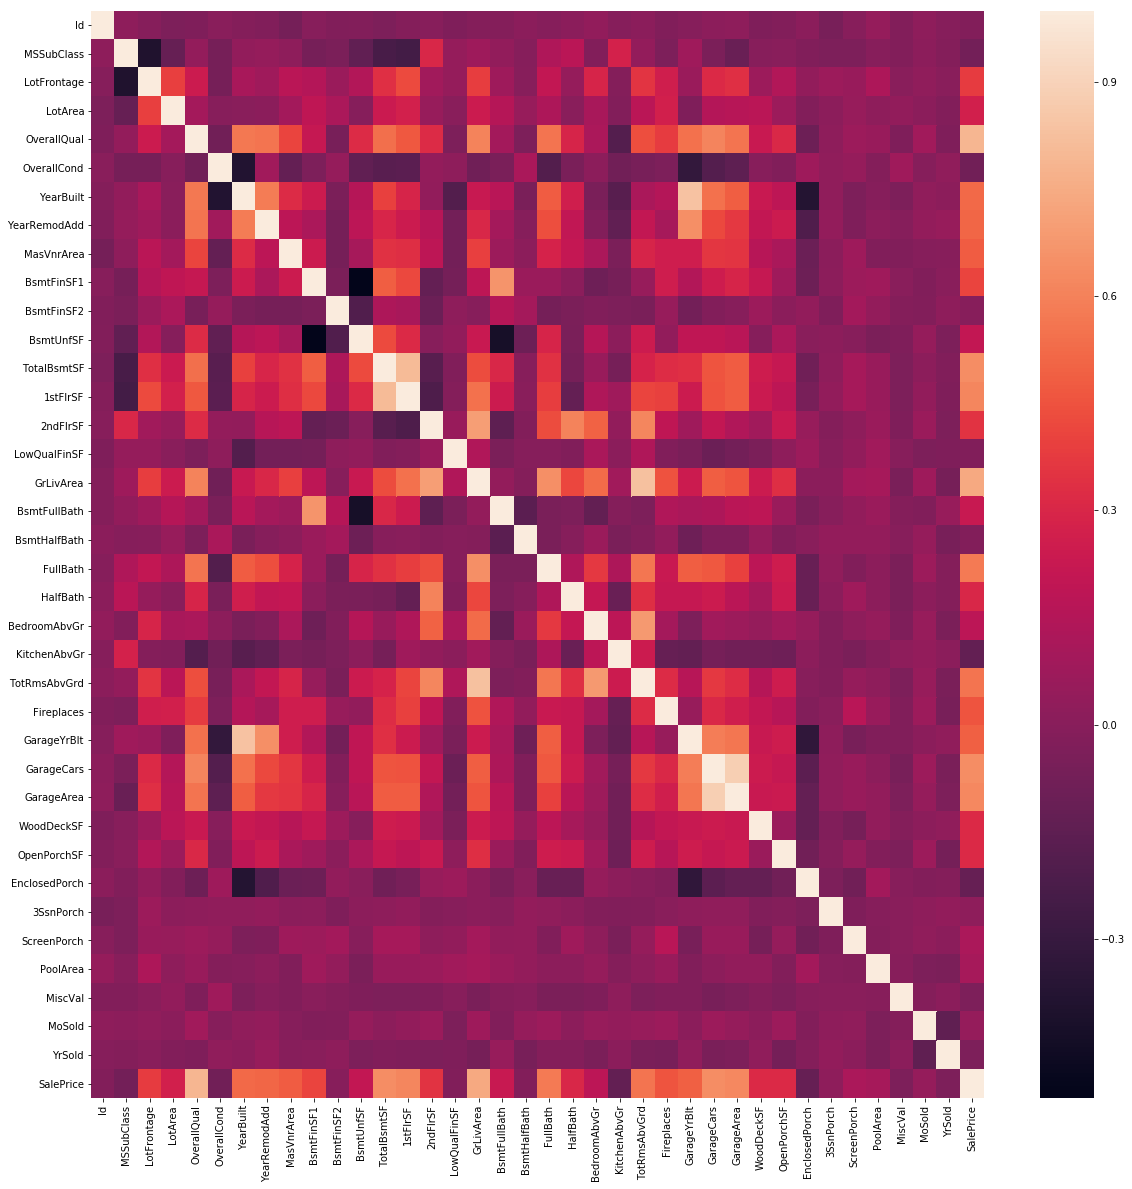

In [66]:
#Heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(matrix_corr, 
        xticklabels=matrix_corr.columns,
        yticklabels=matrix_corr.columns, ax=ax)

In [67]:
#We sort the values of the matrix from the most correlated variable to the sale price to the least correlated one.
print (matrix_corr['SalePrice'].sort_values(ascending=False)[:], '\n')

SalePrice        1.000000
OverallQual      0.789142
GrLivArea        0.740379
TotalBsmtSF      0.641917
GarageCars       0.640961
GarageArea       0.623329
1stFlrSF         0.618556
FullBath         0.571867
TotRmsAbvGrd     0.559435
YearBuilt        0.523194
YearRemodAdd     0.509916
GarageYrBlt      0.489794
MasVnrArea       0.481406
Fireplaces       0.458528
BsmtFinSF1       0.407568
LotFrontage      0.378387
2ndFlrSF         0.348623
OpenPorchSF      0.315548
WoodDeckSF       0.315379
HalfBath         0.299779
LotArea          0.266811
BsmtFullBath     0.221209
BsmtUnfSF        0.206050
BedroomAbvGr     0.183829
ScreenPorch      0.119891
PoolArea         0.103644
MoSold           0.047015
3SsnPorch        0.020826
BsmtFinSF2      -0.002920
BsmtHalfBath    -0.017281
Id              -0.019222
LowQualFinSF    -0.027071
MiscVal         -0.036877
YrSold          -0.039841
MSSubClass      -0.075817
OverallCond     -0.082580
EnclosedPorch   -0.119790
KitchenAbvGr    -0.133544
Name: SalePr

Thus the most significant variables in house price prediction are: OverallQual and GrLivArea . Let's get more information about these two variables and their impact on the sale price

In [68]:
houseDF.OverallQual.unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2], dtype=int64)

The overall quality of a house is a grade between 0 and 10. Let's check the median price of a house for each grade.

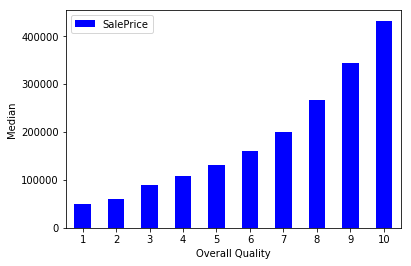

In [69]:
#Creating a pivot table 
quality_pivot = houseDF.pivot_table(index='OverallQual',values='SalePrice', aggfunc=np.median)
quality_pivot.plot(kind='bar',color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median')
plt.xticks(rotation=0)
plt.show()

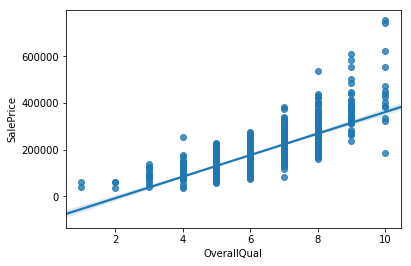

In [70]:
sns.regplot(x='OverallQual',y='SalePrice',data=houseDF)

Here we can clearly see the correlation: The sale price increases directly with the Overall Quality.

The second most correlated variables to the SalePrice is GrLiveArea which gives the grade (ground) living area in square feet.

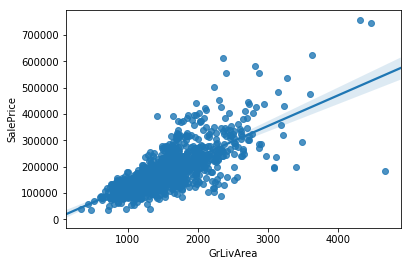

In [71]:
sns.regplot(x='GrLivArea',y='SalePrice',data=houseDF)

SalePrice also increases directly with the variable GrLivArea

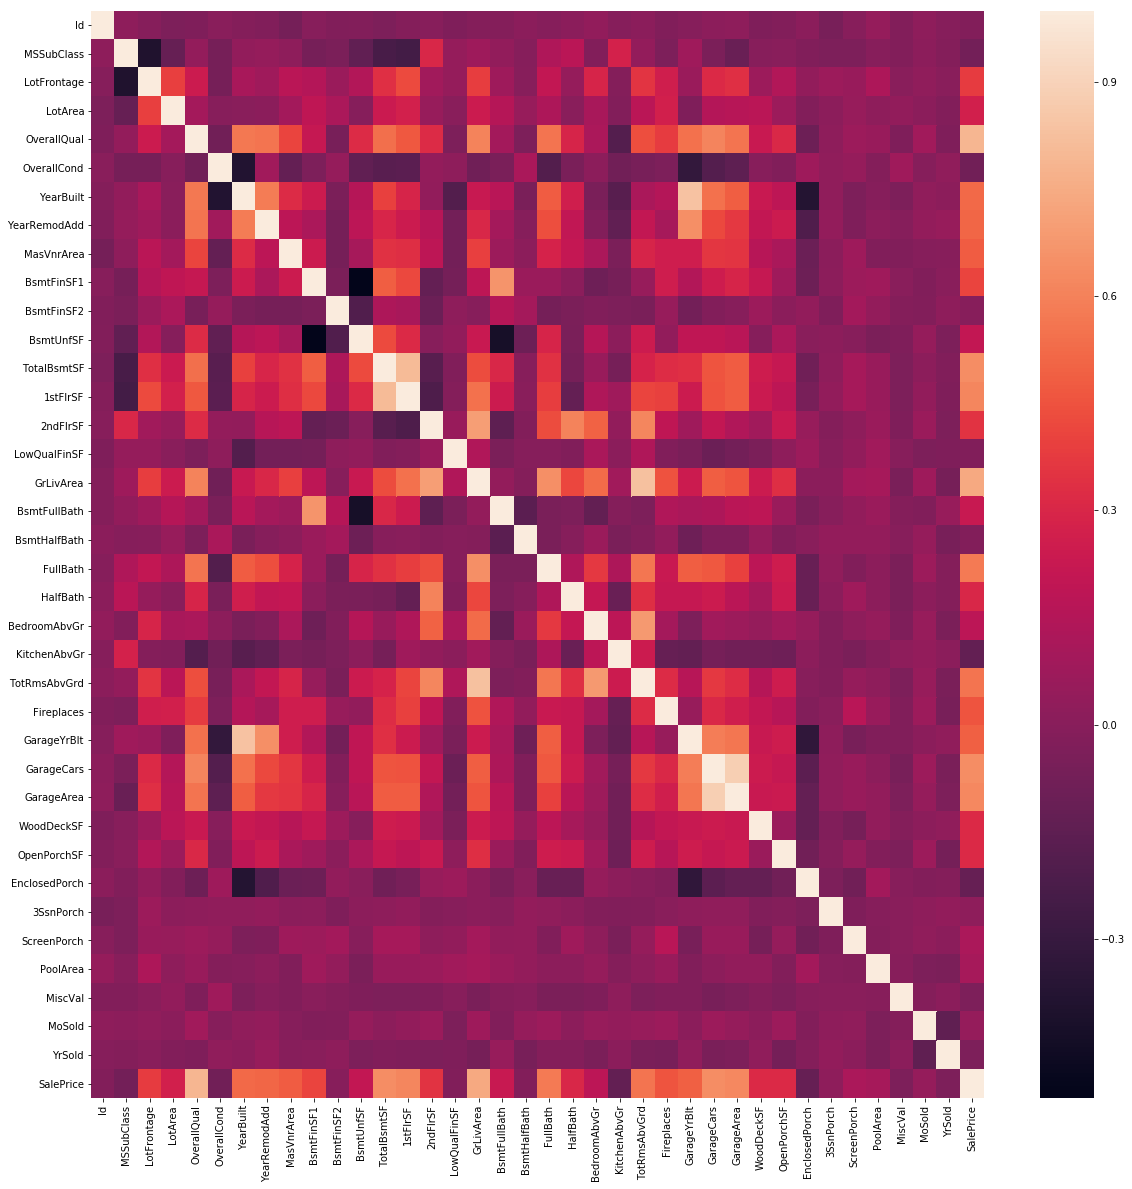

In [72]:
#Heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(matrix_corr, 
        xticklabels=matrix_corr.columns,
        yticklabels=matrix_corr.columns, ax=ax)


Now let's find if there are correlated numerical variables. Visually, by checking the correlation matrix, we can see that the highly correlated variables are the following:
- TotalBsmtSf and 1STFirSF
- GarageCars and GarageArea

Let's verify this numerically:

In [73]:
print(numerical_val[["TotalBsmtSF","1stFlrSF"]].corr())
print(numerical_val[["GarageArea","GarageCars"]].corr())

             TotalBsmtSF  1stFlrSF
TotalBsmtSF     1.000000  0.807276
1stFlrSF        0.807276  1.000000
            GarageArea  GarageCars
GarageArea    1.000000    0.885374
GarageCars    0.885374    1.000000


<div class="">
    <h3>2. Data Pre-processing</h3>
</div>

The previous step should give you a better understanding of which pre-processing is required for the data.
This may include:



- Handling missing information in the dataset;

First we observe that some columns contain mainly NaN values, in the next cell we are going to get rid of the variables that contain more thant 75% of NaN values

In [74]:
#Dropping Columns who's percentage of NaN values is greater than 75%
for col in list(houseDF.columns.values):
    nanValues = float(houseDF[col].isnull().sum()) / len(houseDF)
    if nanValues > 0.75:
        #print col
        houseDF = houseDF.drop([col], axis=1)

In [75]:
print(houseDF.isnull().sum().sort_values(ascending=False))

FireplaceQu      564
LotFrontage      210
GarageFinish      67
GarageType        67
GarageCond        67
GarageQual        67
GarageYrBlt       67
BsmtExposure      33
BsmtFinType2      33
BsmtFinType1      32
BsmtCond          32
BsmtQual          32
MasVnrArea         6
MasVnrType         6
YearRemodAdd       0
RoofStyle          0
Exterior2nd        0
RoofMatl           0
Exterior1st        0
OverallCond        0
ExterQual          0
ExterCond          0
Foundation         0
YearBuilt          0
SalePrice          0
OverallQual        0
HouseStyle         0
BldgType           0
Condition2         0
Condition1         0
                ... 
PavedDrive         0
WoodDeckSF         0
OpenPorchSF        0
3SsnPorch          0
TotRmsAbvGrd       0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
Functional         0
KitchenQual        0
BsmtUnfSF          0
2ndFlrSF           0
TotalBsmtSF        0
SaleCondition

Now let's deal the rest of the missing values. First let's analyze the attribute FirePlaceQu. Our first intuition is that there could be a correlatation between FirePlaceQu and FirePlaces. Then, a missing value means that there is no FirePlaces (FirePlaces=0). Let's see the number of occurations of the value 0 in FirePlaces

In [76]:
len(houseDF.Fireplaces[houseDF.Fireplaces==0])

564

Therefore, we will consider that a missing value in FirePlaceQu means that there is no FirePlace. Then, we can replace the missing values of FirePlaceQu by NF (no fireplace).

In [77]:
houseDF['FireplaceQu'].fillna('NF' ,inplace = True)

For LotFrontage, we only have 210 missing values.It is a numerical attriubte, then we could simply replace the missing values by 0.

In [78]:
houseDF['LotFrontage'].fillna(0 ,inplace = True)

GarageType, GarageYrBlt, GarageFinish, GarageQual and GarageCond all have the same amount of missing values. We could conclude that a missing value means no garage.     

In [79]:
houseDF['GarageType'].fillna('NG' ,inplace = True)
houseDF['GarageYrBlt'].fillna(0 ,inplace = True)
houseDF['GarageFinish'].fillna('NG' ,inplace = True)
houseDF['GarageQual'].fillna('NG' ,inplace = True)
houseDF['GarageCond'].fillna('NG' ,inplace = True)


Same thing for BsmtFinType2, BsmtExposure, BsmtFinType1, BsmtCond and BsmtQual. For the rest of attributes with missing values, we could simply remove the rows with missing values.

In [80]:
houseDF['BsmtFinType2'].fillna('NB' ,inplace = True)
houseDF['BsmtExposure'].fillna('NB' ,inplace = True)
houseDF['BsmtFinType1'].fillna('NB' ,inplace = True)
houseDF['BsmtCond'].fillna('NB' ,inplace = True)
houseDF['BsmtQual'].fillna('NB' ,inplace = True)

In [81]:
houseDF['MasVnrArea'].fillna(0 ,inplace = True)
houseDF=houseDF[houseDF.MasVnrArea != 0]
houseDF['MasVnrType'].fillna(0 ,inplace = True)
houseDF=houseDF[houseDF.MasVnrType != 0]


In [82]:
houseDF.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000
6,7,20,RL,75.0,10084,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,8,2007,WD,Normal,307000
7,8,60,RL,0.0,10382,Pave,IR1,Lvl,AllPub,Corner,...,228,0,0,0,350,11,2009,WD,Normal,200000


- Feature selection:

In [83]:
#Correlation with output variable
cor_target = abs(matrix_corr["SalePrice"])

#Selecting low correlated features
unrelevant_features = cor_target[cor_target<0.1]
unrelevant_features



Id              0.019222
MSSubClass      0.075817
OverallCond     0.082580
BsmtFinSF2      0.002920
LowQualFinSF    0.027071
BsmtHalfBath    0.017281
3SsnPorch       0.020826
MiscVal         0.036877
MoSold          0.047015
YrSold          0.039841
Name: SalePrice, dtype: float64

In [84]:
#Keeping the highly correlated columns
houseDF = houseDF.drop(list(unrelevant_features.index),axis=1)
houseDF.head()

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,SaleType,SaleCondition,SalePrice
0,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,TA,Y,0,61,0,0,0,WD,Normal,208500
2,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,TA,Y,0,42,0,0,0,WD,Normal,223500
4,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,TA,Y,192,84,0,0,0,WD,Normal,250000
6,RL,75.0,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,...,TA,Y,255,57,0,0,0,WD,Normal,307000
7,RL,0.0,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,...,TA,Y,235,204,228,0,0,WD,Normal,200000


We saw in the Data Exploration part that the couples TotalBsmtSF-1stFirSF and GarageArea-GarageCars and highly correlated, let's delete the attributes that are less correlated to the SalePrice, which are 1stFlrSF and GarageArea

In [85]:
houseDF=houseDF.drop(['GarageArea'],axis=1)
houseDF=houseDF.drop(['1stFlrSF'],axis=1)

- Standardizing the data:

In [86]:
# We create the dataframe of numerical values:
numerical_val = houseDF.select_dtypes(include=[np.number])


In [87]:
old_mean=numerical_val['SalePrice'].mean()
old_std=numerical_val['SalePrice'].std()
for col in numerical_val:
    houseDF[col]= (numerical_val[col]-numerical_val[col].mean())/numerical_val[col].std()    
houseDF.head()
    

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,SaleType,SaleCondition,SalePrice
0,RL,0.169784,-0.249550,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,TA,Y,-0.942881,0.092016,-0.232640,-0.29854,-0.045455,WD,Normal,-0.088535
2,RL,0.252290,0.037566,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,TA,Y,-0.942881,-0.212256,-0.232640,-0.29854,-0.045455,WD,Normal,0.074879
4,RL,0.692321,0.346216,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,TA,Y,0.620144,0.460345,-0.232640,-0.29854,-0.045455,WD,Normal,0.363578
6,RL,0.444803,-0.081997,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,...,TA,Y,1.133011,0.027959,-0.232640,-0.29854,-0.045455,WD,Normal,0.984551
7,RL,-1.617839,-0.051440,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,...,TA,Y,0.970196,2.382060,4.670391,-0.29854,-0.045455,WD,Normal,-0.181136


- Removing outliers;


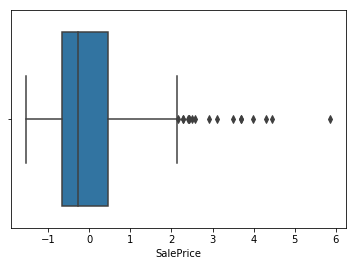

In [88]:
sns.boxplot(x=houseDF['SalePrice'])

The boxplot shows dozens of points more than 325000, these are outliers as there are not included in the box of other observations.

In [89]:
houseDF = houseDF[houseDF.SalePrice <=325000]


- Encoding Categorical variables:

In [90]:
# Dataframe of categorical variables:
categorical_val= houseDF.select_dtypes(include=[np.object])
categorical_val.columns


Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

There are 39 categorical variables, let's  encode each one of them.

In [91]:
houseDF=pd.get_dummies(houseDF)



<div class="">
    <h3>3. Model Selection</h3>
</div>

In [92]:
X = houseDF.drop(['SalePrice'], axis=1)
y= houseDF['SalePrice']

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=42, test_size=.4)

- A simple linear model:

In [94]:
from sklearn import linear_model
lr = linear_model.LinearRegression()

In [95]:
model = lr.fit(X_train, y_train)

In [96]:
print("R^2 for training set is: \n", model.score(X_train, y_train))

R^2 for training set is: 
 0.9495353767679711


In [97]:
print("R^2 for testing set: \n", model.score(X_test, y_test))

R^2 for testing set: 
 -3.4890150481283844e+22


Hence the huge difference between the efficiency over training data and the one over testing data means that there is overfitting. To deal with this problem we will use a a gradient boosting model that produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.

In [98]:
from sklearn import linear_model
from sklearn import ensemble

gb = ensemble.GradientBoostingRegressor()

In [99]:
model1 = gb.fit(X_train, y_train)

In [100]:
print ("R^2 for the training data is: \n", model1.score(X_train, y_train))
print ("R^2 for the testing data is: \n", model1.score(X_test, y_test))

R^2 for the training data is: 
 0.9902662650724903
R^2 for the testing data is: 
 0.8773696840710372


<div class="">
    <h3>4. Parameter Optimisation</h3>
</div>

Irrespective of your choice, it is highly likely that your model will have one or more parameters that require tuning.
There are several techniques for carrying out such a procedure, including cross-validation, Bayesian optimisation, and several others.
As before, an analysis into which parameter tuning technique best suits your model is expected before proceeding with the optimisation of your model.

In [101]:
from sklearn.model_selection import GridSearchCV
p_test3 = {'learning_rate':[0.5,0.25,0.1,0.01,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,2000]}

tuning = GridSearchCV(estimator =ensemble.GradientBoostingRegressor(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3)
tuning.fit(X_train,y_train)
print("Optimal parameters are:\n",tuning.best_params_)
print("Best score is:\n", tuning.best_score_)



C:\Users\kassa\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Optimal parameters are:
 {'learning_rate': 0.25, 'n_estimators': 100}
Best score is:
 0.82134789471328


C:\Users\kassa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<div class="">
    <h3>5. Model Evaluation</h3>
</div>

Some form of pre-evaluation will inevitably be required in the preceding sections in order to both select an appropriate model and configure its parameters appropriately.
In this final section, you may evaluate other aspects of the model such as:

- Assessing the running time of your model;
- Determining whether some aspects can be parallelised;
- Training the model with smaller subsets of the data.
- etc.

In [102]:
test = pd.read_csv(path + 'test.csv', error_bad_lines=False)
submission = pd.DataFrame()
submission['Id'] = test.Id
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1201,20,RL,71.0,9353,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,Shed,0,7,2006,Oth,Abnorml
1,1202,60,RL,80.0,10400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2009,WD,Normal
2,1203,50,RM,50.0,6000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
3,1204,20,RL,75.0,9750,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal
4,1205,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,7,2006,WD,Normal


In [103]:
#First we make the same operations over test than before

#Dealing with the rest of missing values
test['FireplaceQu'].fillna('NF' ,inplace = True)
test['GarageType'].fillna('NG' ,inplace = True)
test['GarageYrBlt'].fillna(0 ,inplace = True)
test['GarageFinish'].fillna('NG' ,inplace = True)
test['GarageQual'].fillna('NG' ,inplace = True)
test['GarageCond'].fillna('NG' ,inplace = True)
test['BsmtFinType2'].fillna('NB' ,inplace = True)
test['BsmtExposure'].fillna('NB' ,inplace = True)
test['BsmtFinType1'].fillna('NB' ,inplace = True)
test['BsmtCond'].fillna('NB' ,inplace = True)
test['BsmtQual'].fillna('NB' ,inplace = True)
test['MasVnrArea'].fillna(0 ,inplace = True)
#Keeping the highly correlated columns
test = test.drop(list(unrelevant_features.index),axis=1)
test=test.drop(['GarageArea'],axis=1)
test=test.drop(['1stFlrSF'],axis=1)
# Standardization:
# We create the dataframe of numerical values:
numerical_val_test = test.select_dtypes(include=[np.number])
for col in numerical_val_test:
    test[col]= (numerical_val_test[col]-numerical_val_test[col].mean())/numerical_val_test[col].std()    
#Encoding categorical variables
test=pd.get_dummies(test)
#We replace the missing values
test = test.interpolate()
#Finally we complete the test data to have the same dimension of training data
for column in X.columns:
    if column not in test.columns:
        test[column]= [0 for k in range(len(test))]
for col in test.columns:
    if col not in X.columns:
        test=test.drop([col], axis=1)




In [104]:
GB = ensemble.GradientBoostingRegressor(learning_rate=0.25, n_estimators=100)

In [105]:
modelFinal = GB.fit(X_train, y_train)

In [106]:
predictions = modelFinal.predict(test)

In [107]:
for i in range(len(predictions)):
    predictions[i] = predictions[i]*old_std + old_mean

In [109]:
submission['SalePrice'] = predictions
submission.head()

,Id,SalePrice
0,1201,122971.460050
1,1202,225476.943604
2,1203,143702.601853
3,1204,215052.921662
4,1205,153610.536042


In [111]:
submission.to_csv("submission.csv")

<div class="alert alert-danger">
    <b>N.B.</b> Please note that the items listed under each heading are neither exhaustive, nor are you expected to explore every given suggestion.
    Nonetheless, these should serve as a guideline for your work in both this and upcoming challenges.
    As always, you should use your intuition and understanding in order to decide which analysis best suits the assigned task.
</div>

#### * Files

* train.csv - The training dataset;
* test.csv - The test dataset;
* data_description.txt - Full description of each column.

#### * Attributes

A brief outline of the available attributes is given below:

* <i>SalePrice</i>: The property's sale price in dollars. This is the target variable that your model is intended to predict;

* <i>MSSubClass</i>: The building class;
* <i>MSZoning</i>: The general zoning classification;
* <i>LotFrontage</i>: Linear feet of street connected to property;
* <i>LotArea</i>: Lot size in square feet;
* <i>Street</i>: Type of road access;
* <i>Alley</i>: Type of alley access;
* <i>LotShape</i>: General shape of property;
* <i>LandContour</i>: Flatness of the property;
* <i>Utilities</i>: Type of utilities available;
* <i>LotConfig</i>: Lot configuration;
* <i>LandSlope</i>: Slope of property;
* <i>Neighborhood</i>: Physical locations within Ames city limits;
* <i>Condition1</i>: Proximity to main road or railroad;
* <i>Condition2</i>: Proximity to main road or railroad (if a second is present);
* <i>BldgType</i>: Type of dwelling;
* <i>HouseStyle</i>: Style of dwelling;
* <i>OverallQual</i>: Overall material and finish quality;
* <i>OverallCond</i>: Overall condition rating;
* <i>YearBuilt</i>: Original construction date;
* <i>YearRemodAdd</i>: Remodel date;
* <i>RoofStyle</i>: Type of roof;
* <i>RoofMatl</i>: Roof material;
* <i>Exterior1st</i>: Exterior covering on house;
* <i>Exterior2nd</i>: Exterior covering on house (if more than one material);
* <i>MasVnrType</i>: Masonry veneer type;
* <i>MasVnrArea</i>: Masonry veneer area in square feet;
* <i>ExterQualv</i>: Exterior material quality;
* <i>ExterCond</i>: Present condition of the material on the exterior;
* <i>Foundation</i>: Type of foundation;
* <i>BsmtQual</i>: Height of the basement;
* <i>BsmtCond</i>: General condition of the basement;
* <i>BsmtExposure</i>: Walkout or garden level basement walls;
* <i>BsmtFinType1</i>: Quality of basement finished area;
* <i>BsmtFinSF1</i>: Type 1 finished square feet;
* <i>BsmtFinType2</i>: Quality of second finished area (if present);
* <i>BsmtFinSF2</i>: Type 2 finished square feet;
* <i>BsmtUnfSF</i>: Unfinished square feet of basement area;
* <i>TotalBsmtSF</i>: Total square feet of basement area;
* <i>Heating</i>: Type of heating;
* <i>HeatingQC</i>: Heating quality and condition;
* <i>CentralAir</i>: Central air conditioning;
* <i>Electrical</i>: Electrical system;
* <i>1stFlrSF</i>: First Floor square feet;
* <i>2ndFlrSF</i>: Second floor square feet;
* <i>LowQualFinSF</i>: Low quality finished square feet (all floors);
* <i>GrLivArea</i>: Above grade (ground) living area square feet;
* <i>BsmtFullBath</i>: Basement full bathrooms;
* <i>BsmtHalfBath</i>: Basement half bathrooms;
* <i>FullBath</i>: Full bathrooms above grade;
* <i>HalfBath</i>: Half baths above grade;
* <i>Bedroom</i>: Number of bedrooms above basement level;
* <i>Kitchen</i>: Number of kitchens;
* <i>KitchenQual</i>: Kitchen quality;
* <i>TotRmsAbvGrd</i>: Total rooms above grade (does not include bathrooms);
* <i>Functional</i>: Home functionality rating;
* <i>Fireplaces</i>: Number of fireplaces;
* <i>FireplaceQu</i>: Fireplace quality;
* <i>GarageType</i>: Garage location;
* <i>GarageYrBlt</i>: Year garage was built;
* <i>GarageFinish</i>: Interior finish of the garage;
* <i>GarageCars</i>: Size of garage in car capacity;
* <i>GarageArea</i>: Size of garage in square feet;
* <i>GarageQual</i>: Garage quality;
* <i>GarageCond</i>: Garage condition;
* <i>PavedDrive</i>: Paved driveway;
* <i>WoodDeckSF</i>: Wood deck area in square feet;
* <i>OpenPorchSF</i>: Open porch area in square feet;
* <i>EnclosedPorch</i>: Enclosed porch area in square feet;
* <i>3SsnPorch</i>: Three season porch area in square feet;
* <i>ScreenPorch</i>: Screen porch area in square feet;
* <i>PoolArea</i>: Pool area in square feet;
* <i>PoolQC</i>: Pool quality;
* <i>Fence</i>: Fence quality;
* <i>MiscFeature</i>: Miscellaneous feature not covered in other categories;
* <i>MiscVal</i>: Value (in dollars) of miscellaneous feature;
* <i>MoSold</i>: Month sold;
* <i>YrSold</i>: Year sold;
* <i>SaleType</i>: Type of sale;
* <i>SaleCondition</i>: Condition of sale.
